In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Get dictionary

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 3: "UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Unicode2ascii

In [4]:

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

## Reading language

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading Lines.......")

    file_name = 'train.csv'

    with open(file_name, encoding='utf-8') as file:
        lines = file.read().strip().split("\n")
        lines = lines[1:]
    print("Lines : ", lines[:3])
    pairs = [[s for s in l.split('\t')] for l in lines]
#     pairs = [list(map(lambda s: s.strip("'"), l.split(', '))) for l in lines]
    print("Pairs:" , pairs[:2])
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

## Filtering Sentences

In [6]:
MAX_LENGTH = 128


## Prepare Data

In [7]:

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Pairs after readLang: ", pairs[13:17])
    
    print("Read {} sentence pairs".format(len(pairs)))
    for p in pairs:
        print(p)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('human', 'machine', False)
print(random.choice(pairs))

Reading Lines.......
Lines :  ['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?\t- number0 number1', 'there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?\t- - number0 number1 number2', "larry 's lawn care charges number0 bucks to trim a hedge . if henry has number1 hedgeshow much money would he spend ?\t* number0 number1"]
Pairs: [['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?', '- number0 number1'], ['there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?', '- - number0 number1 number2']]
Pairs after readLang:  [['isabel received number0 dollars for her birthday . later she found some toys that cost number1 dollars ea

In [8]:
print("Input WordDict: ", input_lang.word2index)
print("Output WordDict : ", output_lang.word2index)


Input WordDict:  {'megan': 3, 'had': 4, 'number0': 5, 'bottles': 6, 'of': 7, 'water': 8, '.': 9, 'if': 10, 'she': 11, 'drank': 12, 'number1': 13, 'themhow': 14, 'many': 15, 'would': 16, 'have': 17, 'left': 18, '?': 19, 'there': 20, 'are': 21, 'books': 22, 'on': 23, 'a': 24, 'shelf': 25, 'them': 26, 'history': 27, 'number2': 28, 'geography': 29, 'and': 30, 'the': 31, 'rest': 32, 'math': 33, '.how': 34, 'larry': 35, "'s": 36, 'lawn': 37, 'care': 38, 'charges': 39, 'bucks': 40, 'to': 41, 'trim': 42, 'hedge': 43, 'henry': 44, 'has': 45, 'hedgeshow': 46, 'much': 47, 'money': 48, 'he': 49, 'spend': 50, 'at': 51, 'bus': 52, 'stop': 53, 'people': 54, 'got': 55, 'off': 56, 'now': 57, 'were': 58, '.what': 59, 'difference': 60, 'between': 61, 'number': 62, 'getting': 63, 'still': 64, 'robyn': 65, 'lucy': 66, 'members': 67, 'their': 68, 'village': 69, 'girl': 70, 'scout': 71, 'troop': 72, 'during': 73, 'weekends': 74, 'some': 75, 'weekdays': 76, 'they': 77, 'go': 78, 'around': 79, 'selling': 80, '

## EncoderRNN

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

## DecoderRNN



In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

## AttentionDecoder

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.3):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, 3) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('human', 'machine', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Testing Functions

In [13]:
test = "It's earth awareness day and the town of flora is celebrating by planting trees in areas where the forest has been damaged . mayor fauna leader of the town of flora donated number0 oak tree seedlings and number1 seedlings of holly . how many seedlings did he donate altogether ?"
print(indexesFromSentence(input_lang, test))
tensorFromSentence(input_lang, test)

[3, 680, 1930, 102, 30, 31, 280, 7, 649, 201, 1931, 246, 434, 655, 82, 1932, 1152, 31, 657, 45, 779, 1933, 9, 1934, 1935, 1936, 7, 31, 280, 7, 649, 645, 5, 1937, 433, 432, 30, 13, 432, 7, 1938, 9, 286, 15, 432, 158, 49, 648, 334, 19]


tensor([[   3,  680, 1930,  102,   30,   31,  280,    7,  649,  201, 1931,  246,
          434,  655,   82, 1932, 1152,   31,  657,   45,  779, 1933,    9, 1934,
         1935, 1936,    7,   31,  280,    7,  649,  645,    5, 1937,  433,  432,
           30,   13,  432,    7, 1938,    9,  286,   15,  432,  158,   49,  648,
          334,   19,    1]])

In [14]:
test = '+ * number1 number0 number2'
print(indexesFromSentence(output_lang, test))
tensorFromSentence(output_lang, test)

[8, 7, 5, 4, 6]


tensor([[8, 7, 5, 4, 6, 1]])

## Train Epoch

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

## Time Calculation

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Train

In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        print("Epoch: {} -------".format(epoch))
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        torch.save(encoder.state_dict(), 'saved_models_128/encoder_epoch{}.pth'.format(epoch))
        torch.save(decoder.state_dict(), 'saved_models_128/decoder_epoch{}.pth'.format(epoch))
        print('Model saved for epoch: {}'.format(epoch))
        

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting results


In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

## Generate Test Pairs

In [20]:
# print("Reading Test Lines.......")

# test_file_name = 'data/test_data.txt'

# with open(test_file_name, encoding='utf-8') as file:
#     test_lines = file.read().strip().split("\n")
# print("Lines : ", test_lines[:3])
# test_pairs = [[s for s in l.split(', ')] for l in test_lines]

# print("Pairs:" , test_pairs[:2])

In [21]:
# print("Pairs after readLang: ", test_pairs[13:17])

# print("Read {} sentence pairs".format(len(test_pairs)))

# for pair in test_pairs[:10]:
#     print(pair)


In [22]:
def evaluate_test(encoder, decoder, test_pairs):
    test_op = []
    for pair in test_pairs:
        print('Input >', pair[0])
        print('Target =', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ''.join(output_words[:-1])
        print('Output <', output_sentence)
        print('')
        test_op.append(output_sentence)
    return test_op

In [23]:
## > input, = target, < output
def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input >', pair[0])
        print('Target =', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('Output <', output_sentence)
        print('')

## Training 

In [24]:
hidden_size = 1024
batch_size = 4

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)



Reading Lines.......
Lines :  ['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?\t- number0 number1', 'there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?\t- - number0 number1 number2', "larry 's lawn care charges number0 bucks to trim a hedge . if henry has number1 hedgeshow much money would he spend ?\t* number0 number1"]
Pairs: [['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?', '- number0 number1'], ['there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?', '- - number0 number1 number2']]
Pairs after readLang:  [['isabel received number0 dollars for her birthday . later she found some toys that cost number1 dollars ea

In [41]:
train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1)

Epoch: 1 -------
Model saved for epoch: 1
47m 36s (- 904m 26s) (1 5%) 0.0023
Epoch: 2 -------


KeyboardInterrupt: 

In [32]:
# torch.save(encoder.state_dict(), 'encoder_2.pth')
# torch.save(decoder.state_dict(), 'decoder_2.pth')

In [42]:
encoder.load_state_dict(torch.load('saved_models_128/encoder_epoch1.pth'))
decoder.load_state_dict(torch.load('saved_models_128/decoder_epoch1.pth'))

<All keys matched successfully>

In [43]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

Input > tyler an animal rights advocate decided to build his own animal sanctuary to protect different animals from poachers . the sanctuary was divided into different regions . the first region to be built was a bird sanctuary . initially he had number0 endangered bird species on that region . if each species has number1 pairs of birdshow many pairs does he have in total ?
Target = * number0 number1
Output < * number0 number1 <EOS>

Input > a teacher had number0 worksheets to grade . if she graded number1 but then another number2 were turned inhow many worksheets would she have to grade ?
Target = + - number0 number1 number2
Output < + - number0 number1 number2 <EOS>

Input > at the river number0 out of number1 salmon families went to warmer waters to avoid being frozen .how many salmon families were left in the river ?
Target = - number1 number0
Output < - number1 number0 <EOS>

Input > when he arrived there he went on to climb to the top of the falls . it usually takes number0 minut

## Visualizing Attention

input = saturday december 27 1834
output Tokens= ["'", '1', '8', '3', '4', '-', '1', '2', '-', '2', '7', "'", '<EOS>']
output= '1834-12-27'<EOS>



<Figure size 640x480 with 0 Axes>

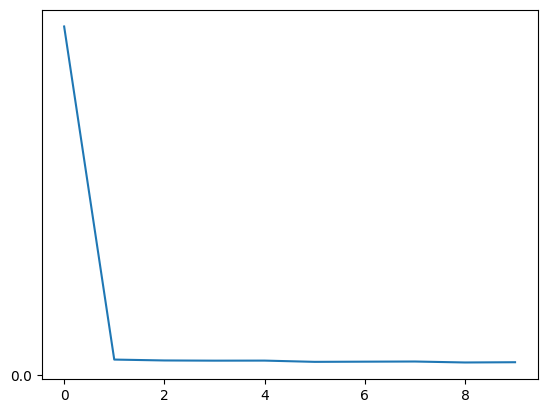

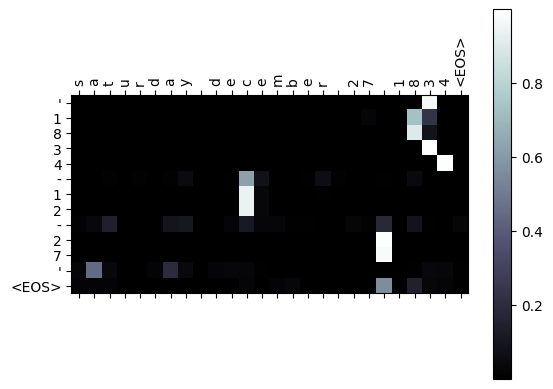

input = 21 september 1712
output Tokens= ["'", '1', '7', '1', '2', '-', '0', '9', '-', '2', '1', "'", '<EOS>']
output= '1712-09-21'<EOS>



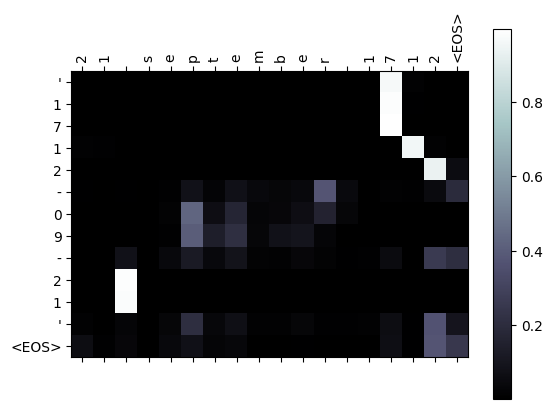

In [29]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
#     print('Input : ', input_sentence)
#     print('Output: ', output_words)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)
    print("")
    # Set up axes
    ax.xaxis.set_ticks([float(i) for i in range(len(list(input_sentence)) + 1)])
#     ax.set_xticklabels(["'"]+list(input_sentence) + ["'"] +
#                        ['<EOS>'], rotation=90)
    ax.set_xticklabels(list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.yaxis.set_ticks([float(i) for i in range(len(output_words))])
    ax.set_yticklabels(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig("images/image.png")
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output Tokens=', output_words)
    print('output=', ''.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


# evaluateAndShowAttention("'may 20 2034'")

# evaluateAndShowAttention("'1746 11 june'")

evaluateAndShowAttention('saturday december 27 1834')

evaluateAndShowAttention('21 september 1712')

In [30]:
# output, _ = evaluate(encoder, decoder, "'april 1 saturday 2011'", input_lang, output_lang)

In [31]:
# ''.join(output)
# ''.join(output[1:-2])

### Accuracy 

# Load encoder and decoder 

In [36]:
encoder.load_state_dict(torch.load('saved_models/encoder_epoch50.pth'))
decoder.load_state_dict(torch.load('saved_models/decoder_epoch50.pth'))

<All keys matched successfully>

In [55]:
# test_op = evaluate_test(encoder, decoder, test_pairs)

NameError: name 'test_pairs' is not defined

In [203]:
# with open("outputs.txt", "w") as output:
#     for out in test_op:
#         output.write(out + '\n')
        

In [38]:
# def findErrorExactMatch(test_pairs, test_op):
#     total = len(test_pairs)
#     count = 0
#     for i in range(total):
#         if(test_pairs[i][1] == test_op[i]):
#             count+=1
#         else:
#             print("{} -- {}".format(test_pairs[i][1] , test_op[i]))
#     print("Accuracy : {}".format(round(count/total,2)))
#     return count

In [39]:
# findErrorExactMatch(test_pairs, test_op)

'2020-10-11' -- '2020-10-111'
'1644-11-11' -- '1644-11-111'
'1738-01-25' -- '1838-01-25'
'1545-03-26' -- '1845-03-26666266666266666626
'2024-12-09' -- '1824-12-09'
'1551-02-06' -- '1851-02-066'
'1573-11-18' -- '1873-11-188-1818'
'2004-01-12' -- '1804-01-12'
'1526-11-21' -- '1526-11-213'
'1879-04-11' -- '1879-04-111'
'2058-03-19' -- '1858-03-199'
'1749-05-11' -- '1849-05-111'
'1553-09-13' -- '1853-09-13'
'1555-03-19' -- '1855-03-19'
'1618-08-20' -- '2018-08-20'
'1904-06-25' -- '1804-06-25'
'1733-08-03' -- '1833-08-03'
'1716-10-11' -- '181610-110-110'
'1737-04-22' -- '1837-04-22'
'1528-09-15' -- '1828-09-15'
'1773-11-09' -- '1873-11-09'
'2014-05-07' -- '1814-05-07'
'2059-01-23' -- '1859-01-23'
'1628-01-21' -- '1628-01-211'
'1857-12-22' -- '1857-12-22222222222222222222
'1565-04-14' -- '1765-04-14'
'1621-01-12' -- '1821-01-12'
'1946-12-31' -- '1947-12-31'
'1754-05-17' -- '1854-05-17'
'1853-01-01' -- '1852-01-01'
'1587-02-26' -- '1787-02-26262666666266266626
'1902-10-05' -- '1802-10-05'
'16

11545

In [40]:
# def charLevelMatch(test_pairs, test_op):
#     total = len(test_pairs)
#     count = [0 for i in range(10)]
#     for i in range(total):
#         for j in range(min(10, min(len(test_pairs[i][1]), len(test_op[i])))):
#             label = test_pairs[i][1]
#             pred = test_op[i]
#             if(label[j] == pred[j]):
#                 count[j] += 1
#     out = list(map(lambda i: round(i/total,2), count))
#     return count, out

In [41]:
# count, accCharLevel = charLevelMatch(test_pairs, test_op)

In [42]:
# count

[12000, 11942, 11646, 11997, 11974, 11998, 11998, 11989, 11998, 11999]

In [43]:
# error = [(12000 - i)  for i in count]

In [45]:
# error

[0, 58, 354, 3, 26, 2, 2, 11, 2, 1]

In [46]:
# accCharLevel

[1.0, 1.0, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Average Error char level -- number of mismatches averaged over all 10 outputs

In [47]:
sumError = sum(error)/10

In [48]:
sumError/12000

0.003825

### Highest Char Level error

In [ ]:
3

### Lowest Char Level error

In [ ]:
1

### Save model

# Final Model for ArithTrain

In [44]:
class ArithSolver(nn.Module):
    def __init__(self):
        super(ArithSolver, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.hidden_size = 1024
        self.batch_size = 4
        input_lang, output_lang, train_dataloader = get_dataloader(self.batch_size);
        self.encoder = EncoderRNN(input_lang.n_words, self.hidden_size).to(device)
        self.decoder = AttnDecoderRNN(self.hidden_size, output_lang.n_words).to(device)
        
        print("Loading Encoder Decoder State Dict---------------------------")
        self.encoder.load_state_dict(torch.load('saved_models_128/encoder_epoch1.pth'))
        self.decoder.load_state_dict(torch.load('saved_models_128/decoder_epoch1.pth'))
        print("Loading Completed--------------------------------------------")
    def solver(self, expression, inp):
#         print('Expression : ', expression)
#         print("InputData: ", inp)
#         print("Solver called")
        model.eval()
        def is_operand(c):
            """
            Return True if the given char c is an operand, e.g. it is a number
            """
            return c!='+' and c!='-' and c!='*' and c!='/'
        if(isinstance(expression, str)):
            expression = expression.split()
        expression = [i for i in expression if i!= 'SOS' and i!='<EOS>']

        if(len(expression) == 0 or len(expression) > 15):
            return -1
        stack = []
#         print("Equation: " , expression)
        # iterate over the string in reverse order
        for c in expression[::-1]:
#             print("char: ", c)
#             print(stack)
            # push operand to stack
            if is_operand(c):
                if(inp.get(c) == None):
                    print('Returned due to key not existing')
                else:
                    stack.append(inp[c])

            else:
                # pop values from stack can calculate the result
                # push the result onto the stack again
                try: 
                    o1 = stack.pop()
                    o2 = stack.pop()
                except:
                    print('Returned due to stack empty')
                    return -1

                if c == '+':
                    stack.append(o1 + o2)

                elif c == '-':
                    stack.append(o1 - o2)

                elif c == '*':
                    stack.append(o1 * o2)

                elif c == '/':
                    stack.append(o1 / o2)

#         print('Answer : ', stack)
        return stack.pop()
        
    
    def forward(self, inp):
#         print("Forward Function Called")
        output_words, _ = evaluate(self.encoder, self.decoder, inp, input_lang, output_lang)
        output_sentence = ' '.join(output_words)
#         print('Output <', output_sentence)
        equation = output_sentence.split()
        return equation
    

In [45]:
model = ArithSolver()

Reading Lines.......
Lines :  ['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?\t- number0 number1', 'there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?\t- - number0 number1 number2', "larry 's lawn care charges number0 bucks to trim a hedge . if henry has number1 hedgeshow much money would he spend ?\t* number0 number1"]
Pairs: [['megan had number0 bottles of water . if she drank number1 of themhow many bottles would megan have left ?', '- number0 number1'], ['there are number0 books on a shelf . number1 of them are history books number2 of them are geography books and the rest are math books .how many math books are there on the shelf ?', '- - number0 number1 number2']]
Pairs after readLang:  [['isabel received number0 dollars for her birthday . later she found some toys that cost number1 dollars ea

Loading Encoder Decoder State Dict---------------------------
Loading Completed--------------------------------------------


In [46]:
eq = model.forward("haley 's old washing machine could only wash number0 pieces of clothing at a time . if she had to wash number1 shirts and number2 sweaters	how many loads would she have to do ?")

In [50]:
# eq = ['SOS','SOS','SOS','SOS','SOS','SOS','<EOS>']
print(eq)
eq = [i for i in eq if i!= 'SOS' and i!='<EOS>']
eq

['/', 'number1', 'number2']


['/', 'number1', 'number2']

In [51]:
inp = '7 2 33'
inp = list(map(int, inp.split()))
print(inp)
inpdict = {}
for i in range(len(inp)):
    inpdict['number' + str(i)] = inp[i] 
print(inpdict)

[7, 2, 33]
{'number0': 7, 'number1': 2, 'number2': 33}


In [52]:
model.solver(eq, inpdict)

0.06060606060606061

In [174]:
df.columns

Index(['input', 'Input Numbers', 'Equation', 'Output'], dtype='object')

# Evaluate on val set

In [36]:
import pandas as pd
df = pd.read_csv('test.csv')

In [37]:
df.head()

,input,Input Numbers,Equation,Output
0,luke was played number0 rounds of a trivia gam...,5 300,/ number1 number0,60.0
1,there are number0 students in the class . the ...,32 5,/ number0 number1,6.4
2,henry bought number0 new fireworks and his fri...,2 3 6,+ + number0 number1 number2,11.0
3,annie is about to celebrate her birthday next ...,15 10 30,+ + number0 number1 number2,55.0
4,there were number0 people on the train . after...,48 31,- number0 number1,17.0


In [38]:
def getData(inp):
    inp = list(map(float, inp.split()))
#     print(inp)
    inpdict = {}
    for i in range(len(inp)):
        inpdict['number' + str(i)] = inp[i] 
    return inpdict

In [40]:
correct = 0
total = 0
for index, row in df.iterrows():
    model_input = row['input']
    data = getData(row['Input Numbers'])
    eq = model.forward(model_input)
    out = model.solver(eq, data)
    if(out == float(row['Output']) or out == int(row['Output']) or round(out,2) == round(row['Output'], 2)):
        correct += 1
    else:
        print('Input : ', model_input)
        print('Model Output Equation: ', eq)
        print('Required Equation: ', row['Equation'])
        print('Output: ', out)
        print('Target: ', row['Output'])
        print('-' * 100)
    total += 1
print("Correct: ", correct)
print("Total: ", total)

print("Accuracy: ", correct/total)

Input :  luke was played number0 rounds of a trivia game and scored number1 points . if he gained the same number of points each roundhow many points did he score per round ?
Model Output Equation:  ['SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'S

Input :  there are number0 people attending a luncheon . if a table can hold number1 peoplehow many tables do they need ?
Model Output Equation:  ['SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS',

Input :  tommy has $ number0 . he wants to buy a $ number1 camera . he also wants to buy a $ number2 cd player .how much more money does tommy need ?
Model Output Equation:  ['-', '-', 'number0', 'number1', 'number2', '<EOS>']
Required Equation:  - + number1 number2 number0
Output:  -15.0
Target:  15.0
----------------------------------------------------------------------------------------------------
Input :  while playing a trivia game team a scored number0 points team b scored number1 points and team c scored number2 points .how many points were scored total ?
Model Output Equation:  ['+', '*', 'number1', 'number0', 'number2', '<EOS>']
Required Equation:  + + number0 number1 number2
Output:  22.0
Target:  15.0
----------------------------------------------------------------------------------------------------
Input :  it takes number0 feet of cotton to make a tee-shirt .how many tee-shirts can be made with number1 feet of material ?
Model Output Equation:  ['/', 'number0', 'number1'

Returned due to key not existing
Returned due to stack empty
Input :  a mirror store has number0 mirrors in stock . number1 mirrors are broken and number2 mirrors are sold .how many mirrors are left ?
Model Output Equation:  ['-', 'number0', 'number3', '<EOS>']
Required Equation:  - - number0 number1 number2
Output:  -1
Target:  13.0
----------------------------------------------------------------------------------------------------
Input :  there are number0 bananas in janice 's banana collection . janice also has number1 crayons . if the bananas are organized into number2 groupshow big is each group ?
Model Output Equation:  ['SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 

Input :  andy had number0 baseball cards . his dad gave him some more . then andy had number1 baseball cards .how many baseball cards did andy get from his dad ?
Model Output Equation:  ['-', 'number0', 'number1', '<EOS>']
Required Equation:  - number1 number0
Output:  -19.0
Target:  19.0
----------------------------------------------------------------------------------------------------
Input :  a worksheet had number0 problems on it . if a teacher had number1 worksheets to grade and had already graded number2 of themhow many more problems does she have to grade ?
Model Output Equation:  ['-', '-', 'number0', 'number1', 'number2', '<EOS>']
Required Equation:  * - number1 number2 number0
Output:  -10.0
Target:  16.0
----------------------------------------------------------------------------------------------------
Input :  being concerned with the ecology of lakes hazel and her dad returned the youngling fishes they caught . if they took number0 fishes from lake ontario and erie numbe

Input :  charlene made number0 bead necklaces . she sold number1 at a craft fair . she gave number2 to her friends .how many necklaces did charlene have then ?
Model Output Equation:  ['+', 'number0', '+', 'number2', 'number1', '<EOS>']
Required Equation:  - - number0 number1 number2
Output:  94.0
Target:  26.0
----------------------------------------------------------------------------------------------------
Input :  miki bought number0 packs of red bouncy balls and number1 packs of yellow bouncy balls . each package contained number2 bouncy balls .how many more packs of red bouncy balls than yellow bouncy balls did miki buy ?
Model Output Equation:  ['-', 'number0', '*', 'number1', 'number2', '<EOS>']
Required Equation:  - number0 number1
Output:  -17.0
Target:  1.0
----------------------------------------------------------------------------------------------------
Input :  she wants to know how many children will go trick or treating in their village . if there are number0 children

Input :  the school bought number0 basketballs and distribute them into number1 classes equally .how many basketballs did each class get ?
Model Output Equation:  ['SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SO

Input :  amy uploaded number0 pics to facebook . if she put the pics into number1 albums with the same number of photos in each albumhow many photos were in each album ?
Model Output Equation:  ['SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 